# Analysis of Seq_2_seq task

In [1]:
from transformers import AutoModelForSeq2SeqLM
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, LoraConfig, TaskType
import torch
from datasets import load_dataset
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import default_data_collator, get_linear_schedule_with_warmup
from tqdm import tqdm
from datasets import load_dataset
from peft import PeftModel, PeftConfig
import numpy as np
import matplotlib.pyplot as plt

/home/aida-user/.pyenv/versions/3.10.9/envs/dl_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### dataset

label_column = "text_label"
max_length = 128 
text_column = "sentence"
model_name_or_path = "bigscience/mt0-large"
batch_size = 2

dataset = load_dataset("financial_phrasebank", "sentences_allagree")
dataset = dataset["train"].train_test_split(test_size=0.1)
dataset["validation"] = dataset["test"]
del dataset["test"]

classes = dataset["train"].features["label"].names
dataset = dataset.map(
    lambda x: {"text_label": [classes[label] for label in x["label"]]},
    batched=True,
    num_proc=1,
)

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)


def preprocess_function(examples):
    inputs = examples[text_column]
    targets = examples[label_column]
    model_inputs = tokenizer(inputs, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt")
    labels = tokenizer(targets, max_length=3, padding="max_length", truncation=True, return_tensors="pt")
    labels = labels["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels
    return model_inputs


processed_datasets = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["validation"]

train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)

print(f'Length of train_dataloader: {len(train_dataloader)}')
print(f'Length of eval_dataloader: {len(eval_dataloader)}')

Found cached dataset financial_phrasebank (/home/aida-user/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
100%|██████████| 1/1 [00:00<00:00, 1058.37it/s]
                                                                                          

Length of train_dataloader: 1019
Length of eval_dataloader: 114


We can see that from this very small train datasets in just two epochs we were able to achive subtastancial accuracy.

In [5]:
f = open('seq_2_seq_output.txt', 'r')
g = open('lora_train_log.txt', 'r')

lines = [line for line in f.readlines()]
lines_train = [line for line in g.readlines()]

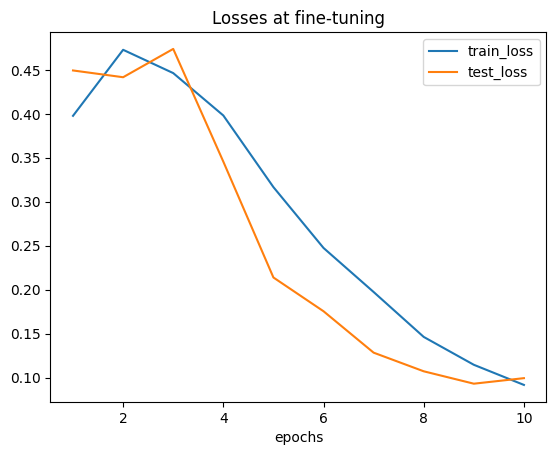

In [6]:
train_loss = []
test_loss = []

for line in lines_train[7::3]:
    train_loss.append(float(line.split()[3][-7:-1]))
    test_loss.append(float(line.split()[-2][-7:-1]))
    
train_loss = np.array(train_loss)
test_loss = np.array(test_loss)

x = np.arange(1, len(test_loss)+1, 1)

plt.plot(x, train_loss, label = "train_loss")
plt.plot(x, test_loss, label = 'test_loss')
plt.title("Losses at fine-tuning")
plt.xlabel("epochs")
plt.legend()

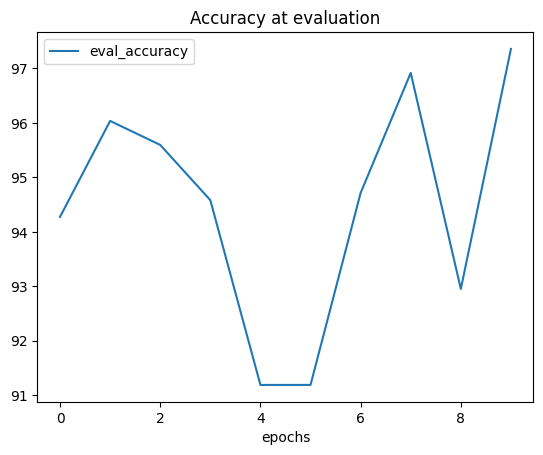

In [7]:
accuracies = []
for line in lines[:41:2][2::2]:
    accuracies.append(float(line.split()[0][9:]))
accuracies = np.array(accuracies)
plt.plot(accuracies, label = 'eval_accuracy')
plt.xlabel("epochs")
plt.title('Accuracy at evaluation')
plt.legend()

We actually managed to achieve 95% just a few epochs! And this is extremely large model, it weights around 11GB in GPU RAM.

In [7]:

model_name_or_path = "bigscience/mt0-large"
tokenizer_name_or_path = "bigscience/mt0-large"
checkpoint_name = "financial_sentiment_analysis_lora_v1.pt"
text_column = "sentence"
label_column = "text_label"    
#peft_config = LoraConfig(task_type=TaskType.SEQ_2_SEQ_LM, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)

Some weights of MT5ForConditionalGeneration were not initialized from the model checkpoint at bigscience/mt0-large and are newly initialized: ['decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
### dataset
num_epochs = 10

dataset = load_dataset("financial_phrasebank", "sentences_allagree")
dataset = dataset["train"].train_test_split(test_size=0.1)
dataset["validation"] = dataset["test"]
del dataset["test"]

classes = dataset["train"].features["label"].names
dataset = dataset.map(
    lambda x: {"text_label": [classes[label] for label in x["label"]]},
    batched=True,
    num_proc=1,
)

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)


def preprocess_function(examples):
    inputs = examples[text_column]
    targets = examples[label_column]
    model_inputs = tokenizer(inputs, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt")
    labels = tokenizer(targets, max_length=3, padding="max_length", truncation=True, return_tensors="pt")
    labels = labels["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels
    return model_inputs


processed_datasets = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["validation"]

train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)

lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

Found cached dataset financial_phrasebank (/home/aida-user/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
100%|██████████| 1/1 [00:00<00:00, 1005.35it/s]


In [9]:
output_file = 'full_fine_tune_output'
f = open(output_file + '.txt', "w")
device = "cuda"

In [10]:
model = model.to(device)
f.write('===== finetuning ======\n')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    model.eval()
    eval_loss = 0
    eval_preds = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
        )

    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)
    f.write(f'losses after {epoch = }\n')
    f.write("f{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=}\n")
    
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=}")
    
    correct = 0
    total = 0
    for pred, true in zip(eval_preds, dataset["validation"]["text_label"]):
        if pred.strip() == true.strip():
            correct += 1
        total += 1
    accuracy = correct / total * 100
    f.write('validation accuracy: \n')
    
    f.write(f"{accuracy=} % on the evaluation dataset after epoch {epoch = }\n")  

  0%|          | 0/1019 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 11.77 GiB total capacity; 5.71 GiB already allocated; 21.38 MiB free; 5.76 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF